[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioRR-Tec/AprendizajeAutomatico/blob/master/Tema_5_AprendizajeProfundo/code/DL_02_Optimizers.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Usaremos la base de datos: Beijing Multi-Site Air-Quality Data Data Set,
# la cual puede ser obtenida desde https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
# (revisar la página para más detalles sobre los datos)
# Se ha proporcionado un archivo csv con la información obtenida de la estación
# de monitoreo Aotizhongxin, el cual contiene 35,064 registros.

# El objetivo es poder predecir la concetración de PM2.5 y de PM10 a partir de las
# variables año, mes, día, hora, temperatura, presión, punto de rocío, 
# precipitación y velocidad del viento.

# Part 1: Load data into Colab

In [5]:
# Import file and store it in a data frame
import io
df = pd.read_csv("../data/PRSA_Aotizhongxin.csv") # Cambia al nombre del archivo que cargues
df.dropna(inplace=True)
df
# Quedan 31,815 registros despues de eliminar NaN's

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


# Part 2: Format data and split it into numpy arrays

In [6]:
# AUX function to put categorical data into one-hot encoding format
from sklearn.preprocessing import OneHotEncoder
def winddir_to_categorical(winddir):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(winddir)
  print("== categories:", enc.categories_, "==")
  return WD

== categories: [array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object)] ==
Input values X with shape (31815, 25). With values
 min = [ 2.013e+03  1.000e+00  1.000e+00  0.000e+00 -1.680e+01  9.859e+02
 -3.530e+01  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00]
 mean = [2.01471491e+03 6.40188590e+00 1.55785636e+01 1.16247996e+01
 1.37756108e+01 1.01180038e+03 3.24110640e+00 6.82351092e-02
 1.72047148e+00 7.51532296e-02 1.12619833e-01 5.05421971e-02
 5.86830112e-02 1.43988685e-01 6.99984284e-02 4.45073079e-02
 5.37482320e-02 3.81581015e-02 3.91010530e-02 2.96715386e-02
 6.03488920e-02 9.57724344e-02 3.36005029e-02 3.14002829e-02
 6.27062706e-02]
 stdd = [ 1.16251735  3.41679338  8.79481542  6.92676545 11.36885668 10.33870697
 13.66764783  0.83747595  1.20422141  0.

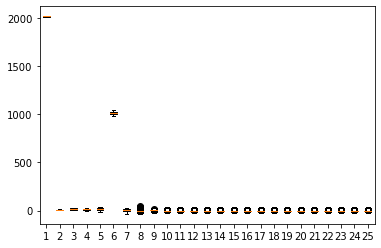

In [7]:
# Extract input features and convert them to a numpy array
X = df[['year', 'month', 'day', 'hour', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].to_numpy()
WD = winddir_to_categorical(df[['wd']])
X = np.concatenate((X, WD), axis=1)

print(f"Input values X with shape {X.shape}. With values")


print(f" min = {X.min(axis=0)}")
print(f" mean = {X.mean(axis=0)}")
print(f" stdd = {X.std(axis=0)}")
print(f" max = {X.max(axis=0)}")

plt.boxplot(X)
plt.show()

[2.01471491e+03 6.40188590e+00 1.55785636e+01 1.16247996e+01
 1.37756108e+01 1.01180038e+03 3.24110640e+00 6.82351092e-02
 1.72047148e+00 7.51532296e-02 1.12619833e-01 5.05421971e-02
 5.86830112e-02 1.43988685e-01 6.99984284e-02 4.45073079e-02
 5.37482320e-02 3.81581015e-02 3.91010530e-02 2.96715386e-02
 6.03488920e-02 9.57724344e-02 3.36005029e-02 3.14002829e-02
 6.27062706e-02]
 min = [-1.47517312 -1.58098114 -1.65763156 -1.67824358 -2.68941826 -2.50518608
 -2.81987851 -0.0814771  -1.42870029 -0.28506174 -0.35624812 -0.23072212
 -0.24968258 -0.41013273 -0.27434832 -0.21582511 -0.23833001 -0.19917808
 -0.20172298 -0.17486812 -0.2534261  -0.32544784 -0.1864638  -0.18005062
 -0.25865307]
 mean = [ 2.53620974e-13 -5.20961380e-15 -1.40856471e-15 -1.27022216e-17
 -1.02426039e-14 -1.09446446e-12 -5.83953233e-16  2.22055074e-15
  1.58522417e-14  1.72582712e-14 -4.05981498e-15  1.36230193e-14
  1.06470074e-14 -1.71220957e-14 -1.80721207e-14  1.59185533e-15
 -1.52863037e-14 -9.66857167e-16 -1.

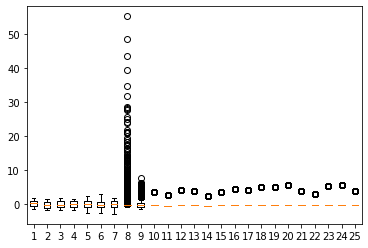

In [8]:
# Normalize (zero-center) and standardize (scale) input data
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X = scalerX.fit_transform(X)
print(scalerX.mean_)

print(f" min = {X.min(axis=0)}")
print(f" mean = {X.mean(axis=0)}")
print(f" stdd = {X.std(axis=0)}")
print(f" max = {X.max(axis=0)}")

plt.boxplot(X)
plt.show()

Target values Y with shape (31815, 2). With values
 min = [3. 2.]
 mean = [81.86363036 58.97633192]
 stdd = [80.44822547 37.06080184]
 max = [713. 290.]


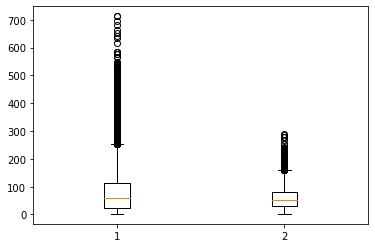

In [9]:
# Extract output features and convert them to a numpy array
Y = df[['PM2.5', 'NO2']].to_numpy()

print(f"Target values Y with shape {Y.shape}. With values")
print(f" min = {Y.min(axis=0)}")
print(f" mean = {Y.mean(axis=0)}")
print(f" stdd = {Y.std(axis=0)}")
print(f" max = {Y.max(axis=0)}")

plt.boxplot(Y)
plt.show()

[81.86363036 58.97633192]
 min = [-0.98030292 -1.53737451]
 mean = [-3.21603501e-17  1.42934889e-17]
 stdd = [1. 1.]
 max = [7.84524911 6.23363923]


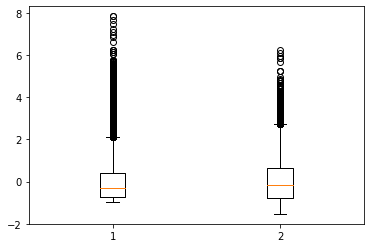

In [10]:
# Normalize (zero-center) and standardize (scale) output data
scalerY = StandardScaler()
Y = scalerY.fit_transform(Y)
print(scalerY.mean_)

print(f" min = {Y.min(axis=0)}")
print(f" mean = {Y.mean(axis=0)}")
print(f" stdd = {Y.std(axis=0)}")
print(f" max = {Y.max(axis=0)}")

plt.boxplot(Y)
plt.show()

In [11]:
# Split data into train+val and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(30224, 25)
(30224, 2)
(1591, 25)
(1591, 2)


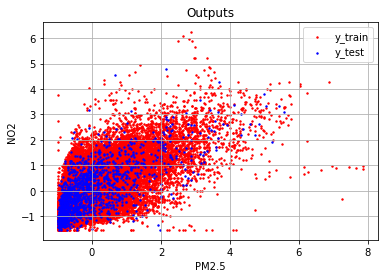

In [12]:
# Plot y_test
# Esta gráfica es para ver sólo si los sets de entrenamiento y test cubren las mismas
# áreas (¿tienen la misma distribución?). No se espera que los puntos coincidan ya que
# son dos sets distintos.
plt.scatter(y_train[:, 0], y_train[:, 1], c='r', s=2, label='y_train')
plt.scatter(y_test[:, 0], y_test[:, 1], c='b', s=2, label='y_test')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Outputs')
plt.show()

# Part 3: Create DNN model and train it

In [13]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1ty

In [14]:
# Create a Deep Network
DNN = Sequential()
DNN.add(Input(shape=X.shape[1:], name='INPUT'))

DNN.add(Dense(units=256, activation='relu'))
DNN.add(Dense(units=512, activation='relu'))
DNN.add(Dense(units=1024, activation='relu'))
DNN.add(Dense(units=512, activation='relu'))
DNN.add(Dense(units=256, activation='relu'))

DNN.add(Dense(units=Y.shape[1], activation='linear', name='OUTPUT'))

DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6656      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
OUTPUT (Dense)               (None, 2)                 514       
Total params: 1,320,194
Trainable params: 1,320,194
Non-trainable params: 0
______________________________________________

In [15]:
# Define training parameters
#from tensorflow.keras.optimizers import SGD
#sgd = SGD(learning_rate=0.02, momentum=0.6)
#DNN.compile(optimizer=sgd, loss='mse')
DNN.compile(optimizer='adam', loss='mse')

In [16]:
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size=32, epochs=200, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/200
851/851 [==============================] - 6s 7ms/step - loss: 0.6252 - val_loss: 0.5312
Epoch 2/200
851/851 [==============================] - 6s 7ms/step - loss: 0.5182 - val_loss: 0.5096
Epoch 3/200
851/851 [==============================] - 6s 7ms/step - loss: 0.4694 - val_loss: 0.4396
Epoch 4/200
851/851 [==============================] - 6s 8ms/step - loss: 0.4255 - val_loss: 0.4224
Epoch 5/200
851/851 [==============================] - 6s 7ms/step - loss: 0.3923 - val_loss: 0.4011
Epoch 6/200
851/851 [==============================] - 6s 7ms/step - loss: 0.3630 - val_loss: 0.4045
Epoch 7/200
851/851 [==============================] - 6s 7ms/step - loss: 0.3396 - val_loss: 0.3818
Epoch 8/200
851/851 [==============================] - 6s 7ms/step - loss: 0.3324 - val_loss: 0.3576
Epoch 9/200
851/851 [==============================] - 6s 7ms/step - loss: 0.2992 - val_loss: 0.3447
Epoch 10/200
851/851 [==============================] - 5s 6ms/step - loss: 0.2810 - val_lo

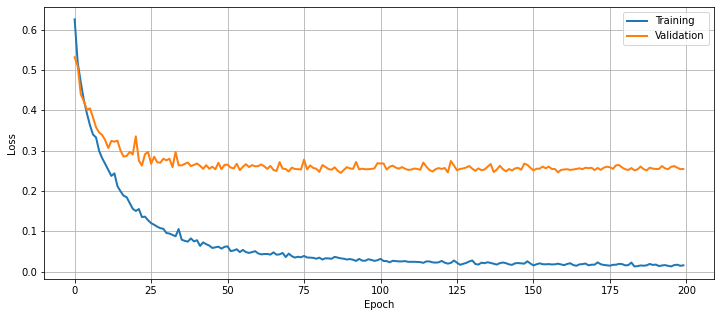

In [17]:
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [18]:
# Generalization metric (opcional)
min_loss = np.min([DNN.history.history['loss'][-1], DNN.history.history['val_loss'][-1]])
max_loss = np.max([DNN.history.history['loss'][-1], DNN.history.history['val_loss'][-1]])
general_loss = (max_loss - min_loss) / max_loss
print(f"Generalization loss: {general_loss:6.4f}%")

Generalization loss: 0.9399%


In [19]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss:", loss_test)

Test loss: 0.2515968978404999


In [20]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

(1591, 2)


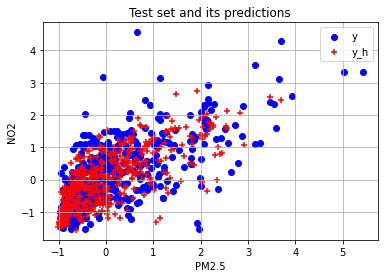

In [21]:
# Plot y_test_hat
indx = np.random.permutation(len(y_test))[:500]
plt.scatter(y_test[indx, 0], y_test[indx, 1], c='b', label='y')
plt.scatter(y_test_hat[indx, 0], y_test_hat[indx, 1], c='r', marker='+', label='y_h')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Test set and its predictions')
plt.show()